# Visualizing Chipotle's Data

This time we are going to pull data directly from the internet.
Special thanks to: https://github.com/justmarkham for sharing the dataset and materials.

### Step 1. Import the necessary libraries

In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
import requests as r
from pyspark.sql.types import DoubleType

In [2]:
spark = SparkSession.builder.master("local[1]").appName("wind").getOrCreate()

22/12/26 16:53:21 WARN Utils: Your hostname, xkeyscore resolves to a loopback address: 127.0.1.1; using 192.168.1.6 instead (on interface wlp0s20f3)
22/12/26 16:53:21 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/26 16:53:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/12/26 16:53:22 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Step 2. Import the dataset from this [address](https://raw.githubusercontent.com/justmarkham/DAT8/master/data/chipotle.tsv). 

In [4]:
chipotle_data = requests.get("https://raw.githubusercontent.com/justmarkham/DAT8/master/data/chipotle.tsv")

### Step 3. Assign it to a variable called chipo.

In [20]:
with open("chipotle.tsv", "w") as f:
    f.write(chipotle_data.text)

In [22]:
chipo=spark.read.csv("chipotle.tsv",inferSchema=True,header=True,sep="\t")

### Step 4. See the first 10 entries

In [26]:
chipo.show(10)

+--------+--------+--------------------+--------------------+----------+
|order_id|quantity|           item_name|  choice_description|item_price|
+--------+--------+--------------------+--------------------+----------+
|       1|       1|Chips and Fresh T...|                NULL|    $2.39 |
|       1|       1|                Izze|        [Clementine]|    $3.39 |
|       1|       1|    Nantucket Nectar|             [Apple]|    $3.39 |
|       1|       1|Chips and Tomatil...|                NULL|    $2.39 |
|       2|       2|        Chicken Bowl|[Tomatillo-Red Ch...|   $16.98 |
|       3|       1|        Chicken Bowl|[Fresh Tomato Sal...|   $10.98 |
|       3|       1|       Side of Chips|                NULL|    $1.69 |
|       4|       1|       Steak Burrito|[Tomatillo Red Ch...|   $11.75 |
|       4|       1|    Steak Soft Tacos|[Tomatillo Green ...|    $9.25 |
|       5|       1|       Steak Burrito|[Fresh Tomato Sal...|    $9.25 |
+--------+--------+--------------------+-----------

### Step 5. Create a histogram of the top 5 items bought

In [38]:
df_chipo = chipo.withColumn('price', F.regexp_replace('item_price','[$]', '').cast(DoubleType()))

In [40]:
df_chipo.show(2)

+--------+--------+--------------------+------------------+----------+-----+
|order_id|quantity|           item_name|choice_description|item_price|price|
+--------+--------+--------------------+------------------+----------+-----+
|       1|       1|Chips and Fresh T...|              NULL|    $2.39 | 2.39|
|       1|       1|                Izze|      [Clementine]|    $3.39 | 3.39|
+--------+--------+--------------------+------------------+----------+-----+
only showing top 2 rows



In [42]:
agg_view = df_chipo.select("item_name","quantity").groupby("item_name").sum().sort("sum(quantity)",ascending=False).limit(5)

In [43]:
agg_view.show()

+-------------------+-------------+
|          item_name|sum(quantity)|
+-------------------+-------------+
|       Chicken Bowl|          761|
|    Chicken Burrito|          591|
|Chips and Guacamole|          506|
|      Steak Burrito|          386|
|  Canned Soft Drink|          351|
+-------------------+-------------+



In [45]:
agg_view_df = agg_view.toPandas()

<AxesSubplot: xlabel='item_name', ylabel='sum(quantity)'>

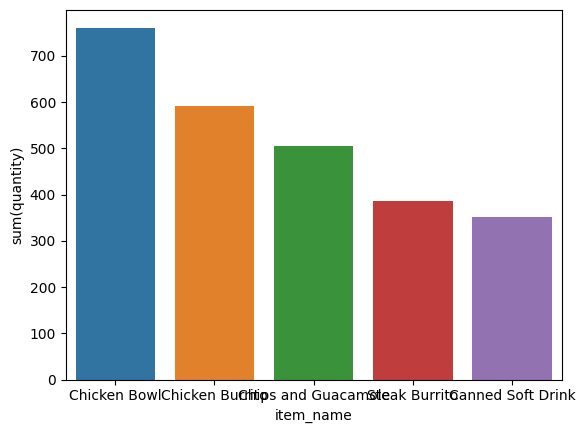

In [50]:
sns.barplot(agg_view_df,x=agg_view_df['item_name'],y=agg_view_df['sum(quantity)'])

### Step 6. Create a scatterplot with the number of items orderered per order price
#### Hint: Price should be in the X-axis and Items ordered in the Y-axis

In [52]:
df_chipo.show()

+--------+--------+--------------------+--------------------+----------+-----+
|order_id|quantity|           item_name|  choice_description|item_price|price|
+--------+--------+--------------------+--------------------+----------+-----+
|       1|       1|Chips and Fresh T...|                NULL|    $2.39 | 2.39|
|       1|       1|                Izze|        [Clementine]|    $3.39 | 3.39|
|       1|       1|    Nantucket Nectar|             [Apple]|    $3.39 | 3.39|
|       1|       1|Chips and Tomatil...|                NULL|    $2.39 | 2.39|
|       2|       2|        Chicken Bowl|[Tomatillo-Red Ch...|   $16.98 |16.98|
|       3|       1|        Chicken Bowl|[Fresh Tomato Sal...|   $10.98 |10.98|
|       3|       1|       Side of Chips|                NULL|    $1.69 | 1.69|
|       4|       1|       Steak Burrito|[Tomatillo Red Ch...|   $11.75 |11.75|
|       4|       1|    Steak Soft Tacos|[Tomatillo Green ...|    $9.25 | 9.25|
|       5|       1|       Steak Burrito|[Fresh Tomat

In [80]:
new_view = df_chipo.select("quantity","price").groupby("price").sum().sort("sum(quantity)",ascending=False)
new_view.show(4)

+-----+-------------+------------------+
|price|sum(quantity)|        sum(price)|
+-----+-------------+------------------+
| 8.75|          730|            6387.5|
|11.25|          521|           5861.25|
| 9.25|          398|            3681.5|
| 4.45|          349|1553.0500000000097|
+-----+-------------+------------------+
only showing top 4 rows



In [81]:
new_view_df = new_view.toPandas()

<AxesSubplot: xlabel='price', ylabel='sum(quantity)'>

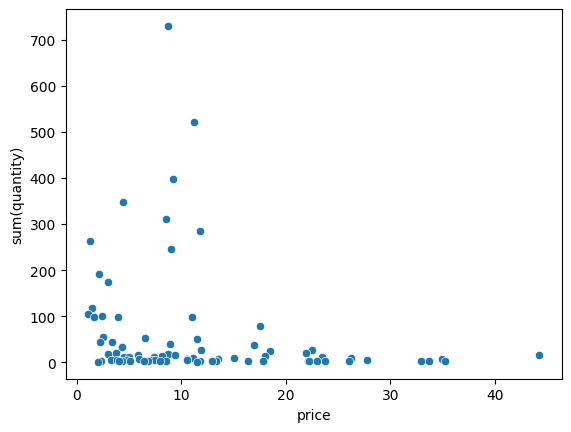

In [82]:
sns.scatterplot(data=new_view_df,x=new_view_df["price"],y=new_view_df["sum(quantity)"])

### Step 7. BONUS: Create a question and a graph to answer your own question.